In [1]:
import datetime
from pathlib import Path
import numpy as np
import xarray as xr
import pyproj
import ppigrf
import matplotlib.pyplot as plt

import verde as vd
import harmonica as hm

/opt/mambaforge/envs/harmonica/lib/python3.10/site-packages/requests/__init__.py:109: RequestsDependencyWarning: urllib3 (1.26.11) or chardet (None)/charset_normalizer (3.0.1) doesn't match a supported version!
  warnings.warn(


In [2]:
def get_inclination_declination(Be, Bn, Bu, degrees=True):
    r"""
    Compute the inclination and declination angles of the IGRF
    The inclination angle is defined as the angle between the magnetic field
    vector and the horizontal plane:
    .. math::
        I = \arctan \frac{-B_u}{\sqrt{B_e^2 + B_n^2}}
    And the declination angle is defined as the azimuth of the projection of
    the magnetic field vector onto the horizontal plane (starting from the
    northing direction, positive to the east and negative to the west):
    .. math::
        D = - \arcsin \frac{B_e}{\sqrt{B_e^2 + B_n^2}}
    Parameters
    ----------
    Be : float or array
        Easting component of the IGRF magnetic vector.
    Bn : float or array
        Northing component of the IGRF magnetic vector.
    Bu : float or array
        Upward component of the IGRF magnetic vector.
    degrees : bool (optional)
        If True, the angles are returned in degrees.
        If False, the angles are returned in radians.
        Default True.
    Returns
    -------
    inclination : float or array
        Inclination angle of the IGRF magnetic vector. If ``degrees`` is True,
        then the angle is returned in degrees. If ``degrees`` is False, then
        it's returned in radians.
    declination : float or array
        Declination angle of the IGRF magnetic vector. If ``degrees`` is True,
        then the angle is returned in degrees. If ``degrees`` is False, then
        it's returned in radians.
    """
    # Compute the horizontal component of B
    horizontal_component = np.sqrt(Be**2 + Bn**2)
    if horizontal_component == 0:
        inclination = -np.sign(Bu) * np.pi /2
        declination = 0
    else:
        # Compute the two angles
        inclination = np.arctan(-Bu / horizontal_component)
        declination = np.arcsin(Be / horizontal_component)
    # Convert to degrees if needed
    if degrees:
        inclination = np.degrees(inclination)
        declination = np.degrees(declination)
    return inclination, declination

In [3]:
data_dir = Path("..") / "data"
grd_file = data_dir / "erie_tf_rtf_122.GRD"

In [4]:
grid = hm.load_oasis_montaj_grid(grd_file)
grid

<xarray.DataArray (northing: 366, easting: 838)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * easting   (easting) float64 2.907e+05 2.912e+05 ... 7.087e+05 7.092e+05
  * northing  (northing) float64 4.569e+06 4.57e+06 ... 4.751e+06 4.752e+06
Attributes: (12/23)
    n_bytes_per_element:  1028
    sign_flag:            2
    shape_e:              838
    shape_v:              366
    ordering:             1
    spacing_e:            500.0
    ...                   ...
    grid_min:             -1.0000000331813535e+32
    grid_max:             -1.0000000331813535e+32
    grid_median:          -1.0000000331813535e+32
    grid_mean:            -1.0000000331813535e+32
    grid_variance:        0.0
    process_flag:         0

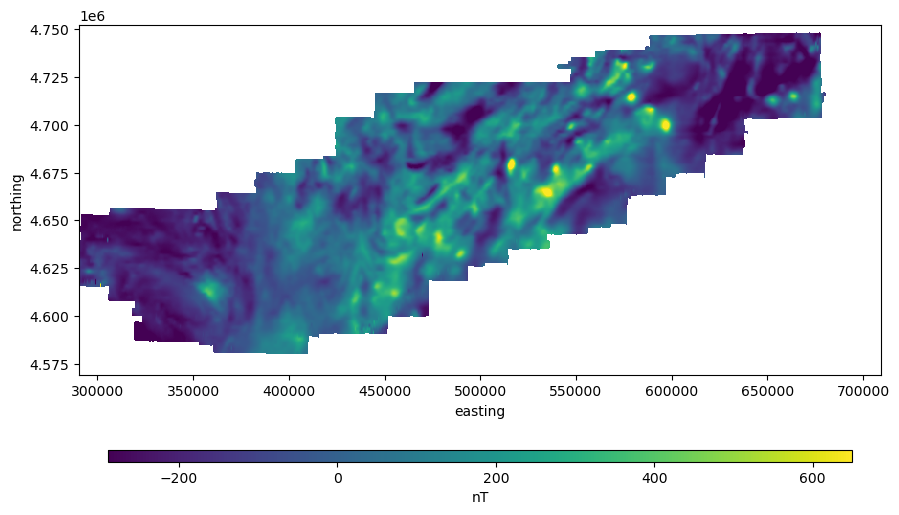

In [5]:
vmin = grid.min() * 0.5
vmax = grid.max() * 0.5
plt.figure(figsize=(12, 6.5))
tmp = grid.plot(add_colorbar=False, vmin=vmin, vmax=vmax, cmap="viridis")
plt.colorbar(tmp, orientation="horizontal", label="nT", aspect=64, shrink=0.8)
plt.gca().set_aspect("equal")
plt.show()

In [6]:
mask = grid.isnull()
mask

<xarray.DataArray (northing: 366, easting: 838)>
array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])
Coordinates:
  * easting   (easting) float64 2.907e+05 2.912e+05 ... 7.087e+05 7.092e+05
  * northing  (northing) float64 4.569e+06 4.57e+06 ... 4.751e+06 4.752e+06

In [7]:
grid = xr.where(grid.isnull(), 0, grid)
grid

<xarray.DataArray (northing: 366, easting: 838)>
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])
Coordinates:
  * easting   (easting) float64 2.907e+05 2.912e+05 ... 7.087e+05 7.092e+05
  * northing  (northing) float64 4.569e+06 4.57e+06 ... 4.751e+06 4.752e+06

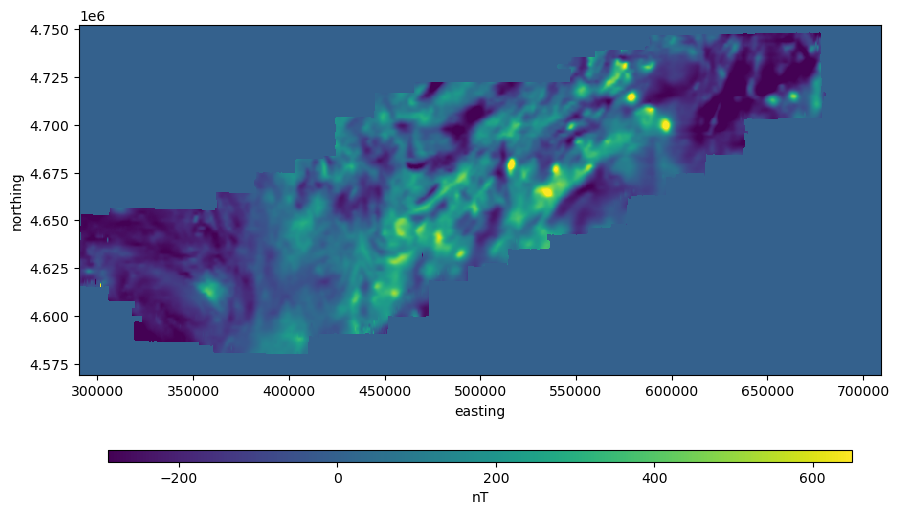

In [8]:
vmin = grid.min() * 0.5
vmax = grid.max() * 0.5
plt.figure(figsize=(12, 6.5))
tmp = grid.plot(add_colorbar=False, vmin=vmin, vmax=vmax, cmap="viridis")
plt.colorbar(tmp, orientation="horizontal", label="nT", aspect=64, shrink=0.8)
plt.gca().set_aspect("equal")
plt.show()

## Reduction to the pole

In [9]:
projection = pyproj.Proj(proj="utm", zone=17, ellps="WGS84")
projection

<Other Coordinate Operation Transformer: utm>
Description: PROJ-based coordinate operation
Area of Use:
- undefined

In [10]:
longitude, latitude = projection(
    grid.easting.mean(), grid.northing.mean(), inverse=True
)
longitude, latitude

(-81.00037791886399, 42.09855483877646)

In [11]:
date = datetime.datetime(year=1984, month=9, day=19)
height = 300

In [12]:
b_e, b_n, b_u = tuple(
    b_i.ravel()[0]
    for b_i in ppigrf.igrf(longitude, latitude, height, date)
)
b_e, b_n, b_u

(-1830.011730928438, 15824.61250763771, -46282.93672222703)

In [13]:
inclination, declination = get_inclination_declination(b_e, b_n, b_u)
inclination, declination

(71.00710294957088, -6.596575738996819)

In [14]:
rtp_grid = hm.reduction_to_pole(grid, inclination=inclination, declination=declination)
rtp_grid.values[mask.values] = np.nan
rtp_grid

<xarray.DataArray (northing: 366, easting: 838)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * northing  (northing) float64 4.569e+06 4.57e+06 ... 4.751e+06 4.752e+06
  * easting   (easting) float64 2.907e+05 2.912e+05 ... 7.087e+05 7.092e+05

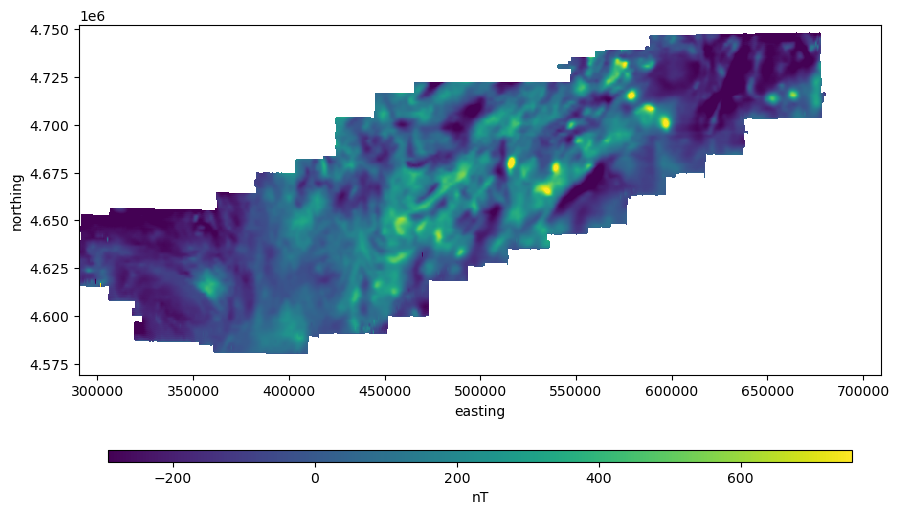

In [15]:
vmin = rtp_grid.min() * 0.5
vmax = rtp_grid.max() * 0.5
plt.figure(figsize=(12, 6.5))
tmp = rtp_grid.plot(add_colorbar=False, vmin=vmin, vmax=vmax, cmap="viridis")
plt.colorbar(tmp, orientation="horizontal", label="nT", aspect=64, shrink=0.8)
plt.gca().set_aspect("equal")
plt.show()

## Upward derivative

In [19]:
upward_deriv = hm.derivative_upward(grid)
upward_deriv.values[mask.values] = np.nan
upward_deriv

<xarray.DataArray (northing: 366, easting: 838)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * northing  (northing) float64 4.569e+06 4.57e+06 ... 4.751e+06 4.752e+06
  * easting   (easting) float64 2.907e+05 2.912e+05 ... 7.087e+05 7.092e+05

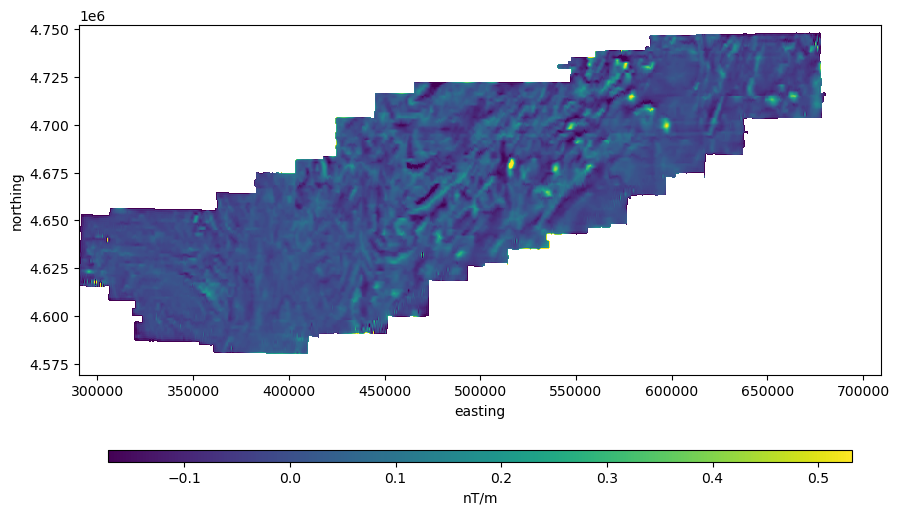

In [21]:
vmin = upward_deriv.min() * 0.1
vmax = upward_deriv.max() * 0.1
plt.figure(figsize=(12, 6.5))
tmp = upward_deriv.plot(add_colorbar=False, vmin=vmin, vmax=vmax, cmap="viridis")
plt.colorbar(tmp, orientation="horizontal", label="nT/m", aspect=64, shrink=0.8)
plt.gca().set_aspect("equal")
plt.show()